In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.datasets import make_regression
import pandas as pd
from sklearn.base import clone
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import cProfile
import pstats
import io
import time
from sklearn.utils import resample

In [ ]:
file_path = 'soybean.csv'
data = pd.read_csv(file_path)

In [ ]:
data = data[:10000]

In [ ]:
X = data.drop(columns=['yield',  'year', 'loc_ID'])
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
print(numerical_features)
y = data['yield'].values
X.shape

Index(['W_1_1', 'W_1_2', 'W_1_3', 'W_1_4', 'W_1_5', 'W_1_6', 'W_1_7', 'W_1_8',
       'W_1_9', 'W_1_10',
       ...
       'P_5', 'P_6', 'P_7', 'P_8', 'P_9', 'P_10', 'P_11', 'P_12', 'P_13',
       'P_14'],
      dtype='object', length=392)


(10000, 392)

In [ ]:
from dataclasses import dataclass





# Function to detect and remove outliers using IQR
def remove_outliers_iqr(df, features):
    for feature in features:
        Q1 = df[feature].quantile(0.005)  # Lower percentile (0.5%)
        Q3 = df[feature].quantile(0.995)  # Upper percentile (99.5%)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    return df


# Remove outliers from numerical features
X = remove_outliers_iqr(X, numerical_features)
print(X.shape)
# Ensure the target variable is aligned with the filtered features
y = y[X.index]

# Pre-processing pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])



# Combine numerical and categorical pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),

    ])

# Dimensionality Reduction (optional)
pca = PCA(n_components=0.95)  # Retain 95% of variance

# Full pipeline with preprocessing and PCA
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', pca)  # Comment this line out if PCA is not needed
])

# Apply the pipeline to the data
X = model_pipeline.fit_transform(X)

# Train-test split
#X_train, X_test, y_train, y_test = train_test_split(X_processed, y_no_outliers, test_size=0.2, random_state=42)

print("Pre-processing completed successfully!")


(9842, 392)
Pre-processing completed successfully!


In [ ]:
X.shape

(9842, 98)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Assume we start with 10 initial labeled examples
initial_labeled_indices = list(np.random.choice(len(X_train), 100, replace=False))



In [ ]:
model = LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mse:.4f}, R2: {r2:.4f}')


MSE: 19.3018, R2: 0.7782


In [ ]:
def plot_metrics(mse_list, r2_list):
    iterations = list(range(1, len(mse_list) + 1))
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(iterations, mse_list, marker='o', label='MSE')
    plt.xlabel('Iteration')
    plt.ylabel('MSE')
    plt.title('MSE over Iterations')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(iterations, r2_list, marker='o', label='R²', color='orange')
    plt.xlabel('Iteration')
    plt.ylabel('R²')
    plt.title('R² over Iterations')
    plt.legend()

    plt.tight_layout()
    plt.show()

Iteration 1: Total labeled indices: 150, MSE=61.2652, R2=0.2960
Iteration 2: Total labeled indices: 200, MSE=40.7286, R2=0.5320
Iteration 3: Total labeled indices: 250, MSE=42.6955, R2=0.5093
Iteration 4: Total labeled indices: 300, MSE=31.2636, R2=0.6407
Iteration 5: Total labeled indices: 350, MSE=27.8110, R2=0.6804
Iteration 6: Total labeled indices: 400, MSE=26.6996, R2=0.6932
Iteration 7: Total labeled indices: 450, MSE=26.4267, R2=0.6963
Iteration 8: Total labeled indices: 500, MSE=24.9716, R2=0.7130
Iteration 9: Total labeled indices: 550, MSE=24.9090, R2=0.7138
Iteration 10: Total labeled indices: 600, MSE=24.4286, R2=0.7193


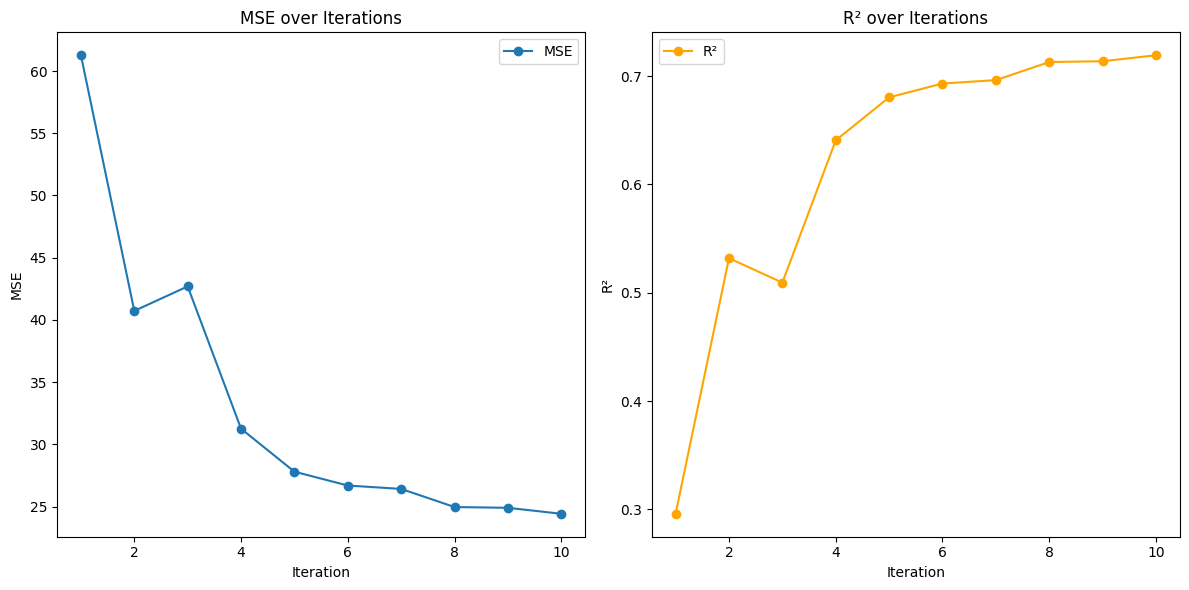

In [ ]:
class RandomSampling:
    def __init__(self, X, y, model='linear'):
        self.X = X
        self.y = y
        self.model_type = model


    def train_model(self, X, y):
        if self.model_type == 'linear':
            model = LinearRegression()
        elif self.model_type == 'gbdt':
            model = GradientBoostingRegressor()
        elif self.model_type == 'rf':
            model = RandomForestRegressor()
        elif self.model_type == 'svm':
            model = SVR(kernel='rbf')
        else:
            raise ValueError("Model type not supported.")
        model.fit(X, y)
        return model

    def select_examples(self, labeled_indices, num_examples):
        unlabeled_indices = list(set(range(len(self.X))) - set(labeled_indices))
        selected_indices = np.random.choice(unlabeled_indices, num_examples, replace=False)
        return selected_indices


    def evaluate_model(self, labeled_indices, X_test, y_test):
        X_labeled = self.X[labeled_indices]
        y_labeled = self.y[labeled_indices]
        model = self.train_model(X_labeled, y_labeled)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        return mse, r2

    def active_learning(self, initial_labeled_indices, X_test, y_test, num_iterations, examples_per_iteration=5):
        labeled_indices = initial_labeled_indices.copy()
        mse_list = []
        r2_list = []
        for i in range(num_iterations):
            new_examples = self.select_examples(labeled_indices, examples_per_iteration)
            labeled_indices.extend(new_examples)
            mse, r2 = self.evaluate_model(labeled_indices, X_test, y_test)
            mse_list.append(mse)
            r2_list.append(r2)
            print(f'Iteration {i+1}: Total labeled indices: {len(labeled_indices)}, MSE={mse:.4f}, R2={r2:.4f}')

        return labeled_indices, mse_list, r2_list





rs = RandomSampling(X_train, y_train, model='linear')  # Use LinearRegression for RandomSampling
labeled_indices, mse_list_rs, r2_list_rs = rs.active_learning(initial_labeled_indices, X_test, y_test, num_iterations=10, examples_per_iteration=50)



plot_metrics(mse_list_rs, r2_list_rs)


Iteration 1: Total labeled indices: 150, MSE=139.0161, R2=-0.5976
Iteration 2: Total labeled indices: 200, MSE=73.1931, R2=0.1589
Iteration 3: Total labeled indices: 250, MSE=51.4699, R2=0.4085
Iteration 4: Total labeled indices: 300, MSE=48.6450, R2=0.4410
Iteration 5: Total labeled indices: 350, MSE=44.9532, R2=0.4834
Iteration 6: Total labeled indices: 400, MSE=41.1575, R2=0.5270
Iteration 7: Total labeled indices: 450, MSE=38.6136, R2=0.5563
Iteration 8: Total labeled indices: 500, MSE=36.2454, R2=0.5835
Iteration 9: Total labeled indices: 550, MSE=33.8656, R2=0.6108
Iteration 10: Total labeled indices: 600, MSE=33.8789, R2=0.6107


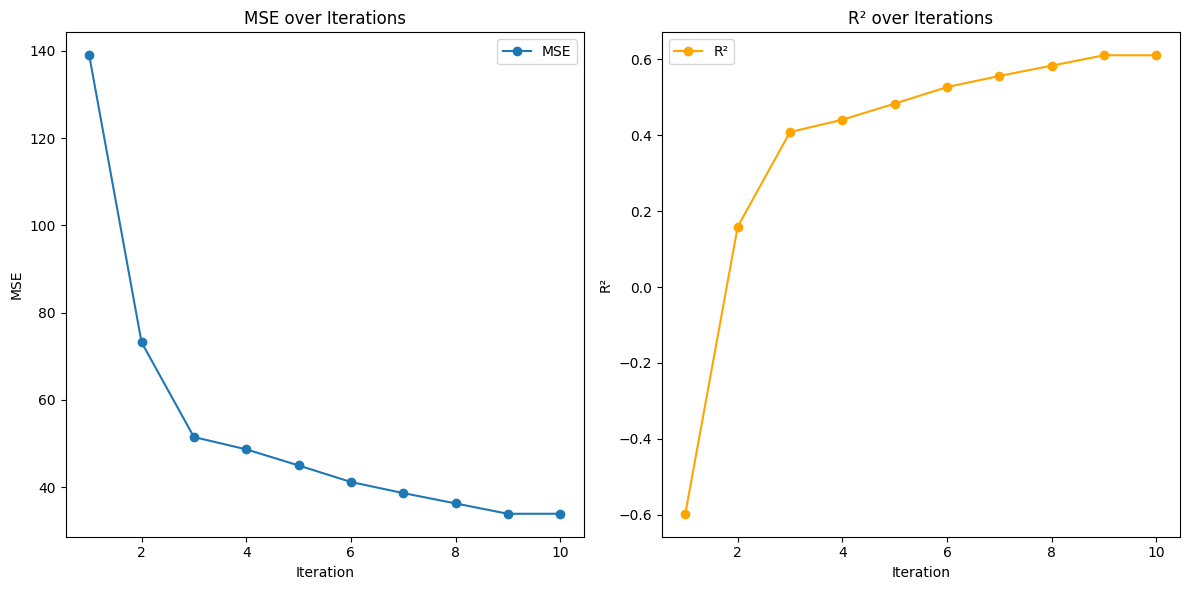

In [ ]:

class EGAL:
    def __init__(self, similarity_threshold=0.5, density_threshold=0.1, model='linear'):
        self.similarity_threshold = similarity_threshold
        self.density_threshold = density_threshold
        self.scaler = StandardScaler()
        self.model_type = model

    def fit(self, X, y):
        self.X = X
        self.y = y
        self.X_scaled = self.scaler.fit_transform(X)
        self.similarity_matrix = euclidean_distances(self.X_scaled)
        self.n = self.similarity_matrix.shape[0]
        self.non_diagonal_elements = np.ravel(self.similarity_matrix[np.triu_indices(self.n, k=1)])
        self.mean_sim = np.mean(self.non_diagonal_elements)
        self.std_sim = np.std(self.non_diagonal_elements)
        self.alpha = self.mean_sim - 0.5 * self.std_sim

    def measure_density(self, idx):
        neighbors = self.similarity_matrix[idx]
        selected_neighbors = neighbors[neighbors < self.alpha]
        density = np.sum(selected_neighbors)
        return density

    def measure_diversity(self, idx, labeled_indices):
        if not labeled_indices:
            return 1
        distances = self.similarity_matrix[idx][labeled_indices]
        return 1 / np.min(distances)

    def select_examples(self, labeled_indices, num_examples=5):
        unlabeled_indices = [i for i in range(len(self.X)) if i not in labeled_indices]
        candidate_set = [idx for idx in unlabeled_indices if self.measure_diversity(idx, labeled_indices) > self.density_threshold]
        densities = [(idx, self.measure_density(idx)) for idx in candidate_set]
        densities.sort(key=lambda x: x[1], reverse=True)
        return [idx for idx, _ in densities[:num_examples]]

    def train_model(self, X, y):
        if self.model_type == 'linear':
            model = LinearRegression()
        elif self.model_type == 'gbdt':
            model = GradientBoostingRegressor()
        elif self.model_type == 'rf':
            model = RandomForestRegressor()
        elif self.model_type == 'svm':
            model = SVR(kernel='rbf')
        else:
            raise ValueError("Model type not supported.")
        model.fit(X, y)
        return model

    def evaluate_model(self, labeled_indices, X_test, y_test):
        X_labeled = self.X[labeled_indices]
        y_labeled = self.y[labeled_indices]
        model = self.train_model(X_labeled, y_labeled)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        return mse, r2

    def active_learning(self, initial_labeled_indices, X_test, y_test, num_iterations, examples_per_iteration=5):
        labeled_indices = initial_labeled_indices.copy()
        mse_list = []
        r2_list = []
        for i in range(num_iterations):
            new_examples = self.select_examples(labeled_indices, examples_per_iteration)
            labeled_indices.extend(new_examples)
            mse, r2 = self.evaluate_model(labeled_indices, X_test, y_test)
            mse_list.append(mse)
            r2_list.append(r2)
            print(f'Iteration {i+1}: Total labeled indices: {len(labeled_indices)}, MSE={mse:.4f}, R2={r2:.4f}')

        return labeled_indices, mse_list, r2_list



egal = EGAL(model='linear')  # Use GradientBoostingRegressor
egal.fit(X_train, y_train)

# Perform active learning for 10 iterations
labeled_indices, mse_list_egal, r2_list_egal = egal.active_learning(initial_labeled_indices, X_test, y_test, num_iterations=10, examples_per_iteration=50)


plot_metrics(mse_list_egal, r2_list_egal)


Iteration 1: Total labeled indices: 150, MSE=83.8668, R2=0.0362
Iteration 2: Total labeled indices: 200, MSE=72.3325, R2=0.1688
Iteration 3: Total labeled indices: 250, MSE=60.3191, R2=0.3068
Iteration 4: Total labeled indices: 300, MSE=46.3096, R2=0.4678
Iteration 5: Total labeled indices: 350, MSE=41.6842, R2=0.5210
Iteration 6: Total labeled indices: 400, MSE=36.9482, R2=0.5754
Iteration 7: Total labeled indices: 450, MSE=34.7247, R2=0.6009
Iteration 8: Total labeled indices: 500, MSE=35.2279, R2=0.5952
Iteration 9: Total labeled indices: 550, MSE=37.4730, R2=0.5694
Iteration 10: Total labeled indices: 600, MSE=36.7838, R2=0.5773


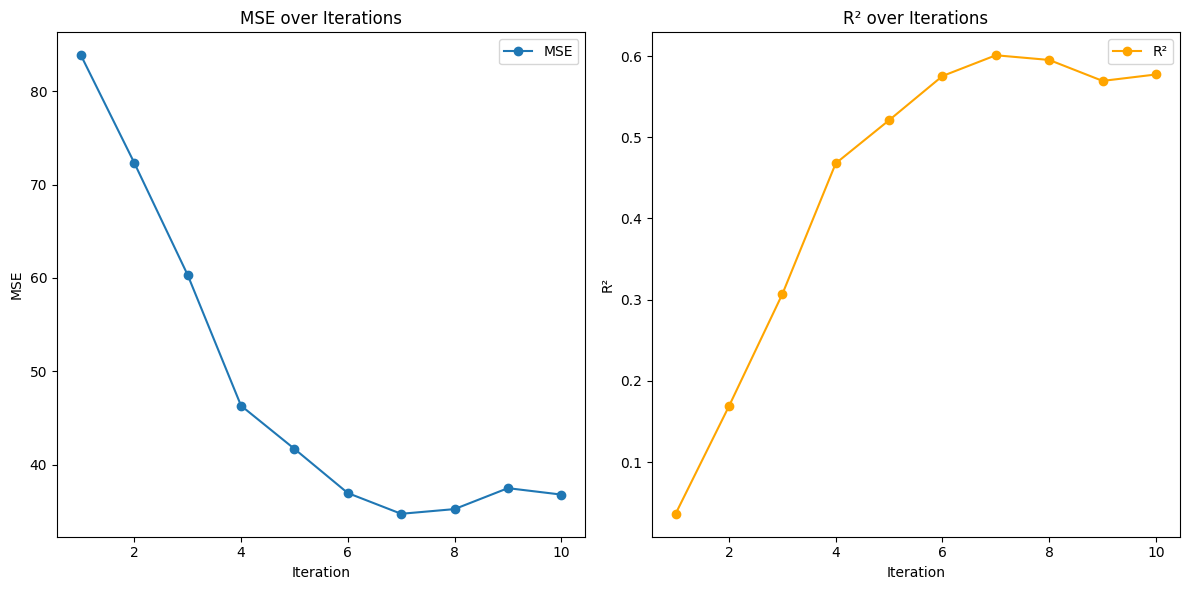

In [ ]:


class EMCM:
    def __init__(self, X, y, model='linear', ensemble_size=10):
        self.X = X
        self.y = y
        self.model_type = model
        self.ensemble_size = ensemble_size
        self.ensemble = []

    def train_model(self, X, y):
        if self.model_type == 'linear':
            model = LinearRegression()
        elif self.model_type == 'gbdt':
            model = GradientBoostingRegressor()
        elif self.model_type == 'rf':
            model = RandomForestRegressor()
        elif self.model_type == 'svm':
            model = SVR(kernel='rbf')
        else:
            raise ValueError("Model type not supported.")
        model.fit(X, y)
        return model

    def construct_ensemble(self, labeled_indices):
        self.ensemble = []
        X_labeled = self.X[labeled_indices]
        y_labeled = self.y[labeled_indices]
        for _ in range(self.ensemble_size):
            X_bootstrap, y_bootstrap = resample(X_labeled, y_labeled)
            model = self.train_model(X_bootstrap, y_bootstrap)
            self.ensemble.append(model)

    def expected_model_change(self, x):
        changes = []
        for model in self.ensemble:
            y_pred = model.predict([x])[0]
            gradient = y_pred - np.mean([model.predict([x])[0] for model in self.ensemble])
            changes.append(np.linalg.norm(gradient * x))
        return np.mean(changes)

    def select_examples(self, labeled_indices, k):
        unlabeled_indices = list(set(range(len(self.X))) - set(labeled_indices))
        expected_changes = []
        for idx in unlabeled_indices:
            change = self.expected_model_change(self.X[idx])
            expected_changes.append((change, idx))
        expected_changes.sort(reverse=True, key=lambda x: x[0])
        return [idx for _, idx in expected_changes[:k]]

    def evaluate_model(self, labeled_indices, X_test, y_test):
        X_labeled = self.X[labeled_indices]
        y_labeled = self.y[labeled_indices]
        model = self.train_model(X_labeled, y_labeled)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        return mse, r2

    def active_learning(self, initial_labeled_indices, X_test, y_test, num_iterations, examples_per_iteration=5):
        labeled_indices = initial_labeled_indices.copy()
        mse_list = []
        r2_list = []
        for i in range(num_iterations):
            self.construct_ensemble(labeled_indices)
            new_examples = self.select_examples(labeled_indices, examples_per_iteration)

            labeled_indices.extend(new_examples)
            mse, r2 = self.evaluate_model(labeled_indices, X_test, y_test)
            mse_list.append(mse)
            r2_list.append(r2)
            print(f'Iteration {i+1}: Total labeled indices: {len(labeled_indices)}, MSE={mse:.4f}, R2={r2:.4f}')

        return labeled_indices, mse_list, r2_list

# Example usage:
# Assuming X and y are your full dataset, and you have separate X_test and y_test for evaluation



emcm = EMCM(X_train, y_train, model='linear')  # Use GradientBoostingRegressor
labeled_indices, mse_list_emcm, r2_list_emcm = emcm.active_learning(initial_labeled_indices, X_test, y_test, num_iterations=10, examples_per_iteration=50)
plot_metrics(mse_list_emcm, r2_list_emcm)


Iteration 1: Total labeled indices: 125, MSE=216.5973, R2=-1.4891
Iteration 2: Total labeled indices: 150, MSE=118.9390, R2=-0.3668
Iteration 3: Total labeled indices: 175, MSE=109.3017, R2=-0.2561
Iteration 4: Total labeled indices: 200, MSE=96.7157, R2=-0.1114
Iteration 5: Total labeled indices: 225, MSE=87.4220, R2=-0.0046
Iteration 6: Total labeled indices: 250, MSE=41.0374, R2=0.5284
Iteration 7: Total labeled indices: 275, MSE=39.7417, R2=0.5433
Iteration 8: Total labeled indices: 300, MSE=35.7317, R2=0.5894
Iteration 9: Total labeled indices: 325, MSE=38.0266, R2=0.5630
Iteration 10: Total labeled indices: 350, MSE=35.7294, R2=0.5894


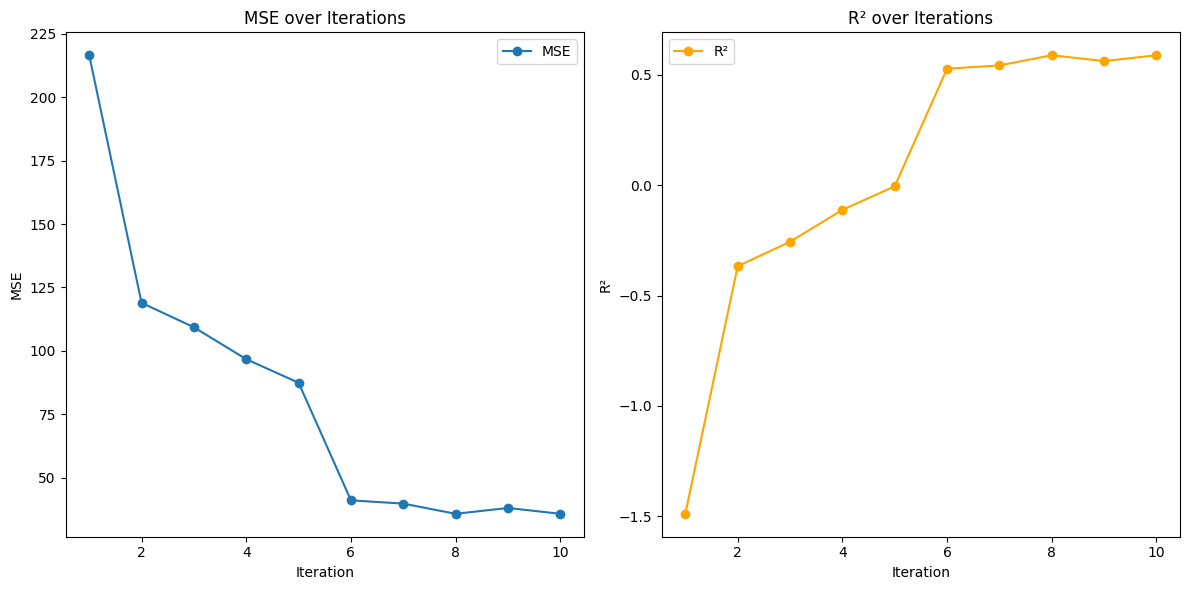

In [ ]:

class QBC:
    def __init__(self, X, y, n_committee=5, model='gbdt'):
        self.X = X
        self.y = y
        self.n_committee = n_committee
        self.models = [self._create_model(model) for _ in range(n_committee)]

    def _create_model(self, model):
        if model == 'rf':
            return RandomForestRegressor()
        elif model == 'gbdt':
            return GradientBoostingRegressor()
        elif model == 'linear':
            return LinearRegression()
        else:
            raise ValueError("Model type not supported")

    def train_committee(self, labeled_indices):
        for model in self.models:
            subset_indices = np.random.choice(labeled_indices, size=len(labeled_indices), replace=True)
            X_subset = self.X[subset_indices]
            y_subset = self.y[subset_indices]
            model.fit(X_subset, y_subset)

    def committee_disagreement(self, x):
        predictions = np.array([model.predict(x.reshape(1, -1))[0] for model in self.models])
        return np.var(predictions)

    def select_examples(self, labeled_indices, num_examples):
        unlabeled_indices = [i for i in range(len(self.X)) if i not in labeled_indices]
        disagreements = [self.committee_disagreement(self.X[i]) for i in unlabeled_indices]
        selected_indices = np.argsort(disagreements)[-num_examples:]
        return [unlabeled_indices[i] for i in selected_indices]

    def evaluate_model(self, labeled_indices, X_test, y_test):
        model = self._create_model('linear')
        X_labeled = self.X[labeled_indices]
        y_labeled = self.y[labeled_indices]
        model.fit(X_labeled, y_labeled)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        return mse, r2

    def active_learning(self, initial_labeled_indices, X_test, y_test, num_iterations, examples_per_iteration=5):
        labeled_indices = initial_labeled_indices.copy()
        mse_list = []
        r2_list = []
        for i in range(num_iterations):
            self.train_committee(labeled_indices)
            new_examples = self.select_examples(labeled_indices, examples_per_iteration)
            labeled_indices.extend(new_examples)
            mse, r2 = self.evaluate_model(labeled_indices, X_test, y_test)
            mse_list.append(mse)
            r2_list.append(r2)
            print(f'Iteration {i+1}: Total labeled indices: {len(labeled_indices)}, MSE={mse:.4f}, R2={r2:.4f}')
        return labeled_indices, mse_list, r2_list




qbc = QBC(X_train, y_train, model='linear')  # Use LinearRegression for QBC
labeled_indices, mse_list_qbc, r2_list_qbc = qbc.active_learning(initial_labeled_indices, X_test, y_test, num_iterations=10, examples_per_iteration=25)


plot_metrics(mse_list_qbc, r2_list_qbc)


Iteration 1: Total labeled indices: 150, MSE=42.9925, R2=0.5059
Iteration 2: Total labeled indices: 200, MSE=32.9513, R2=0.6213
Iteration 3: Total labeled indices: 250, MSE=26.3638, R2=0.6970
Iteration 4: Total labeled indices: 300, MSE=25.8600, R2=0.7028
Iteration 5: Total labeled indices: 350, MSE=24.8093, R2=0.7149
Iteration 6: Total labeled indices: 400, MSE=25.2848, R2=0.7094
Iteration 7: Total labeled indices: 450, MSE=24.3077, R2=0.7207
Iteration 8: Total labeled indices: 500, MSE=24.5985, R2=0.7173
Iteration 9: Total labeled indices: 550, MSE=23.5234, R2=0.7297
Iteration 10: Total labeled indices: 600, MSE=23.1946, R2=0.7335


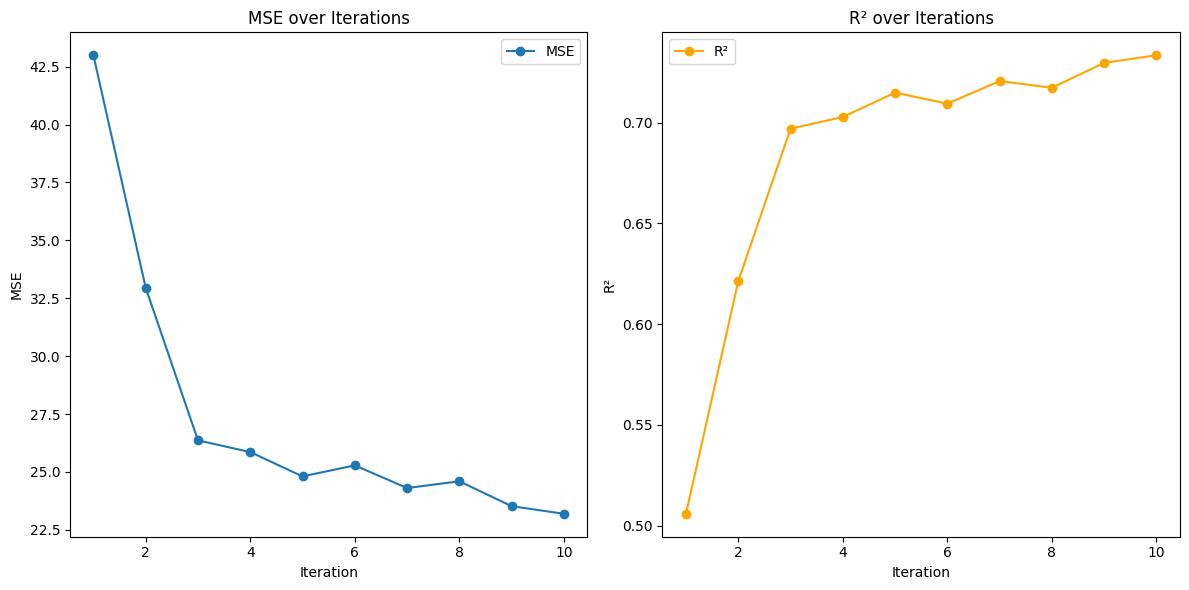

In [ ]:


class GreedySampling:
    def __init__(self, X, y, model='linear'):
        self.X = X
        self.y = y
        self.model_type = model
        self.model = self._create_model(model)

    def _create_model(self, model):
        if model == 'linear':
            return LinearRegression()
        elif model == 'rf':
            return RandomForestRegressor()
        elif model == 'gbdt':
            return GradientBoostingRegressor()
        else:
            raise ValueError("Model type not supported")

    def distance_to_centroid(self, X):
        centroid = np.mean(X, axis=0)
        distances = np.linalg.norm(X - centroid, axis=1)
        return np.argmin(distances)

    def distance_to_labeled(self, X_labeled, X_unlabeled):
        distances = np.min([np.linalg.norm(X_unlabeled - x, axis=1) for x in X_labeled], axis=0)
        return distances



    def select_next_sample_gsx(self, X_labeled, X_unlabeled):
        distances = self.distance_to_labeled(X_labeled, X_unlabeled)
        return np.argmax(distances)

    def select_next_sample_gsy(self, X_labeled, y_labeled, X_unlabeled):
        self.model.fit(X_labeled, y_labeled)
        y_pred_unlabeled = self.model.predict(X_unlabeled)
        distances = np.min([np.abs(y_pred_unlabeled - y) for y in y_labeled], axis=0)
        return np.argmax(distances)

    def select_next_sample_igs(self, X_labeled, y_labeled, X_unlabeled):
        distances_x = self.distance_to_labeled(X_labeled, X_unlabeled)
        self.model.fit(X_labeled, y_labeled)
        y_pred_unlabeled = self.model.predict(X_unlabeled)
        distances_y = np.min([np.abs(y_pred_unlabeled - y) for y in y_labeled], axis=0)
        combined_distances = distances_x * distances_y
        return np.argmax(combined_distances)

    def greedy_sampling(self, initial_indices, X_test, y_test, num_iterations=10, examples_per_iteration=50, strategy='igs'):
        X_labeled = self.X[initial_indices]
        y_labeled = self.y[initial_indices]
        unlabeled_indices = np.setdiff1d(np.arange(len(self.X)), initial_indices)

        mse_scores = []
        r2_scores = []

        for i in range(num_iterations):
            new_indices = []
            for _ in range(examples_per_iteration):
                X_unlabeled = self.X[unlabeled_indices]
                if strategy == 'gsx':
                    next_sample_index = self.select_next_sample_gsx(X_labeled, X_unlabeled)
                elif strategy == 'gsy':
                    next_sample_index = self.select_next_sample_gsy(X_labeled, y_labeled, X_unlabeled)
                elif strategy == 'igs':
                    next_sample_index = self.select_next_sample_igs(X_labeled, y_labeled, X_unlabeled)
                else:
                    raise ValueError("Invalid strategy. Choose from 'gsx', 'gsy', 'igs'.")

                selected_index = unlabeled_indices[next_sample_index]
                new_indices.append(selected_index)
                X_labeled = np.vstack([X_labeled, self.X[selected_index]])
                y_labeled = np.append(y_labeled, self.y[selected_index])
                unlabeled_indices = np.delete(unlabeled_indices, next_sample_index)

            self.model.fit(X_labeled, y_labeled)
            y_pred = self.model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            mse_scores.append(mse)
            r2_scores.append(r2)
            print(f'Iteration {i+1}: Total labeled indices: {len(X_labeled)}, MSE={mse:.4f}, R2={r2:.4f}')

        return X_labeled, y_labeled, mse_scores, r2_scores




gs = GreedySampling(X_train, y_train, model='linear')  # Use LinearRegression for GreedySampling
X_labeled, y_labeled, mse_list_gs, r2_list_gs = gs.greedy_sampling(initial_labeled_indices, X_test, y_test, num_iterations=10, strategy='igs')

plot_metrics(mse_list_gs, r2_list_gs)


Iteration 1: Total labeled indices: 150, MSE=45.6198, R2=0.4757
Iteration 2: Total labeled indices: 200, MSE=34.0710, R2=0.6085
Iteration 3: Total labeled indices: 250, MSE=28.7357, R2=0.6698
Iteration 4: Total labeled indices: 300, MSE=26.2439, R2=0.6984
Iteration 5: Total labeled indices: 350, MSE=25.5187, R2=0.7067
Iteration 6: Total labeled indices: 400, MSE=24.2564, R2=0.7212
Iteration 7: Total labeled indices: 450, MSE=23.6636, R2=0.7281
Iteration 8: Total labeled indices: 500, MSE=22.7558, R2=0.7385
Iteration 9: Total labeled indices: 550, MSE=22.1505, R2=0.7454
Iteration 10: Total labeled indices: 600, MSE=21.9530, R2=0.7477


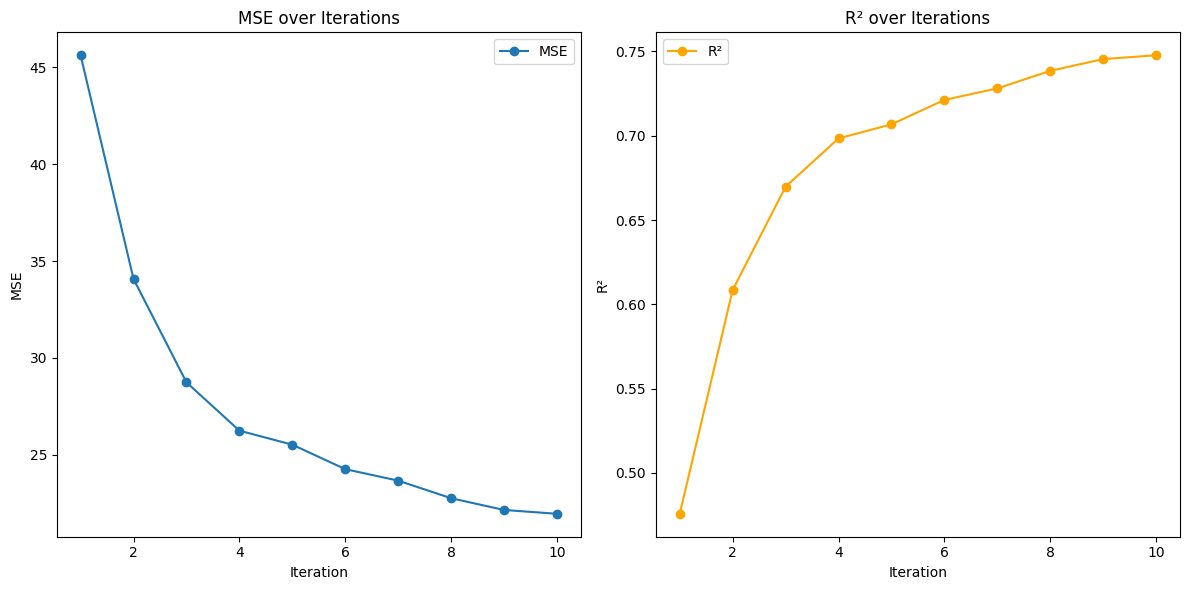

In [ ]:
gs = GreedySampling(X_train, y_train, model='linear')  # Use LinearRegression for GreedySampling
X_labeled, y_labeled, mse_list_gsx, r2_list_gsx = gs.greedy_sampling(initial_labeled_indices, X_test, y_test, num_iterations=10, strategy='gsx')

plot_metrics(mse_list_gsx, r2_list_gsx)

Iteration 1: Total labeled indices: 150, MSE=49.3644, R2=0.4327
Iteration 2: Total labeled indices: 200, MSE=50.1754, R2=0.4234
Iteration 3: Total labeled indices: 250, MSE=35.2082, R2=0.5954
Iteration 4: Total labeled indices: 300, MSE=35.2183, R2=0.5953
Iteration 5: Total labeled indices: 350, MSE=28.9506, R2=0.6673
Iteration 6: Total labeled indices: 400, MSE=28.4355, R2=0.6732
Iteration 7: Total labeled indices: 450, MSE=27.2640, R2=0.6867
Iteration 8: Total labeled indices: 500, MSE=26.9510, R2=0.6903
Iteration 9: Total labeled indices: 550, MSE=26.1124, R2=0.6999
Iteration 10: Total labeled indices: 600, MSE=26.0634, R2=0.7005


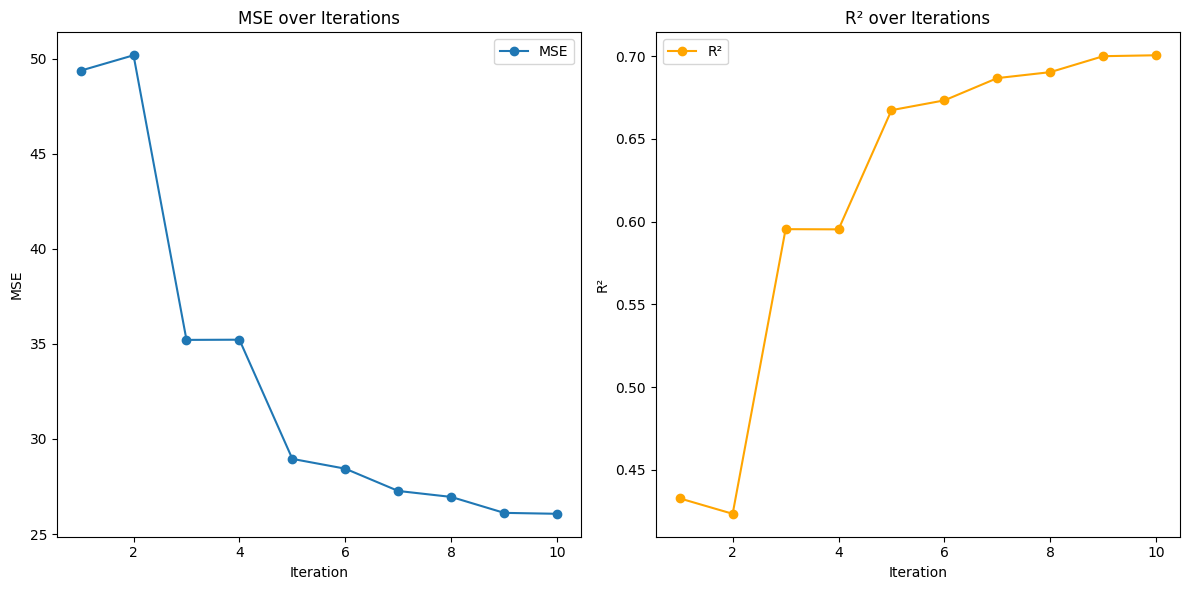

In [ ]:
gs = GreedySampling(X_train, y_train, model='linear')  # Use LinearRegression for GreedySampling
X_labeled, y_labeled, mse_list_gsy, r2_list_gsy = gs.greedy_sampling(initial_labeled_indices, X_test, y_test, num_iterations=10, strategy='gsy')

plot_metrics(mse_list_gsy, r2_list_gsy)

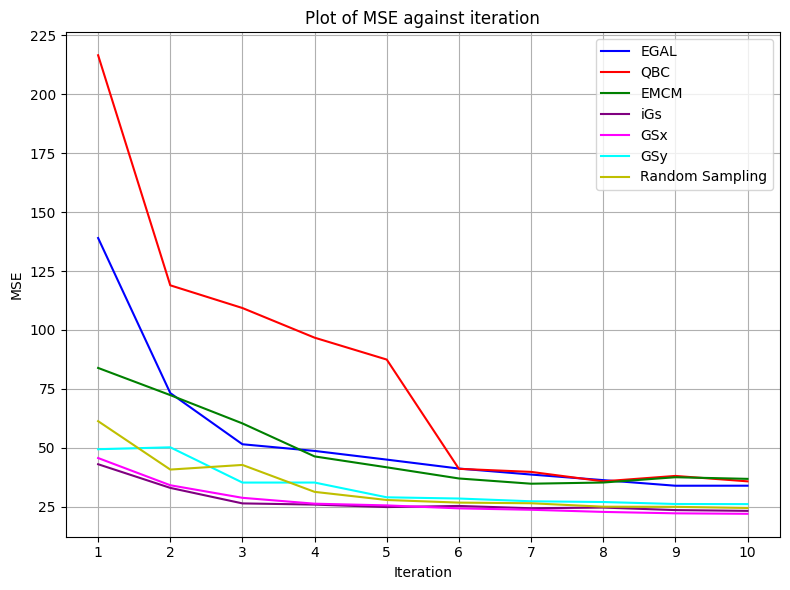

In [ ]:
indices = range(1, len(mse_list_gs) + 1)

# Plot each list against the indices
plt.figure(figsize=(8, 6))  # Adjust figure size as needed

plt.plot(indices, mse_list_egal, linestyle='-', color='b', label='EGAL')
plt.plot(indices, mse_list_qbc, linestyle='-', color='r', label='QBC')
plt.plot(indices, mse_list_emcm, linestyle='-', color='g', label='EMCM')
plt.plot(indices, mse_list_gs, linestyle='-', color='purple', label='iGs')
plt.plot(indices, mse_list_gsx, linestyle='-', color='magenta', label='GSx')
plt.plot(indices, mse_list_gsy, linestyle='-', color='cyan', label='GSy')
plt.plot(indices, mse_list_rs, linestyle='-', color='y', label='Random Sampling')

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.title('Plot of MSE against iteration')
plt.xticks(indices)  # Set x-axis ticks to match indices
plt.grid(True)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


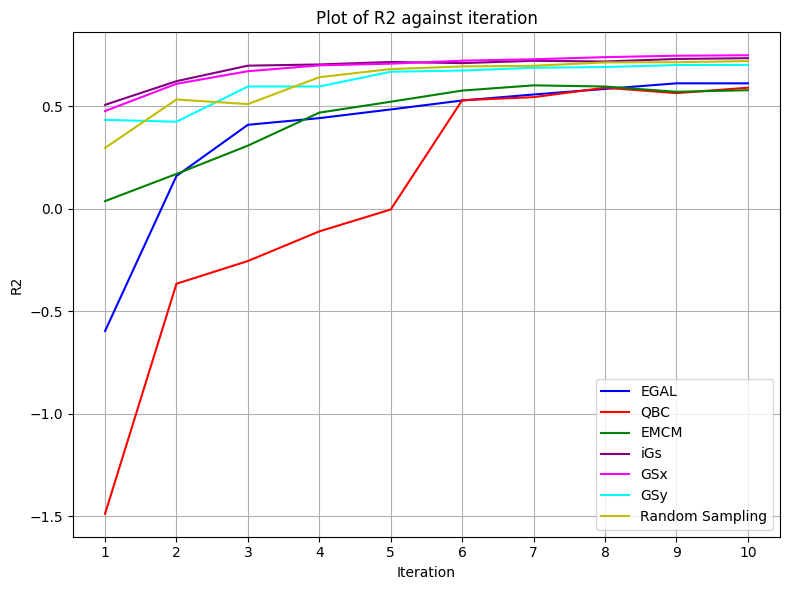

In [ ]:
indices = range(1, len(r2_list_gs) + 1)

# Plot each list against the indices
plt.figure(figsize=(8, 6))  # Adjust figure size as needed

plt.plot(indices, r2_list_egal, linestyle='-', color='b', label='EGAL')
plt.plot(indices, r2_list_qbc, linestyle='-', color='r', label='QBC')
plt.plot(indices, r2_list_emcm, linestyle='-', color='g', label='EMCM')
plt.plot(indices, r2_list_gs, linestyle='-', color='purple', label='iGs')
plt.plot(indices, r2_list_gsx, linestyle='-', color='magenta', label='GSx')
plt.plot(indices, r2_list_gsy, linestyle='-', color='cyan', label='GSy')
plt.plot(indices, r2_list_rs, linestyle='-', color='y', label='Random Sampling')

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('R2')
plt.title('Plot of R2 against iteration')
plt.xticks(indices)  # Set x-axis ticks to match indices
plt.grid(True)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()
